
---

# DL HW2
 - Pretrained Models

In this assignment, you will analyze and compare a few pre-trained models from the field of computer vision.

The assignment is divided into several tasks:

- **EX1 - The Imagenette Dataset (10 pts)**  
- **EX2 - Pretrained Models (20 pts)**  
- **EX3 - Visualizing Feature Maps (30 pts)**  
- **EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50 pts)**  

Note: In this assignment, you will not train any models or aim to reach specific accuracy levels. Instead, you will investigate the behavior of a few pre-trained models.

---

## Grading

The grading for each section is indicated in the title. Grading will be based on the following criteria:

- **Following Instructions**  
- **Presentation**: Clear figures (with labels, titles, etc.), well-written discussions and comments, organized notebook, no leftover debugging prints, and no redundant functions.  
- **Clear and Efficient Code**: Your code should be clear and neat. Write clear comments and avoid `for loops` when vectorized operations are available. Use the GPU when possible.  
- **Discussion**: Ensure you write a discussion whenever it is required.  

---

Submit the fully executed notebook.

---


# EX1 - Imagenette (Small subset of ImageNet) Dataset (10pts)



1.   Download the ```Imagenette``` dataset from ```torchvision``` ([link](https://pytorch.org/vision/0.19/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)). Make sure the set size="160px" to avoid long downloading time.
2. Preprocess the data - resize to 256x256 and take a central crop of size 224. ToTensor, Normalize and so on.
3. Describe the dataset: number of samples for each set, classes labels, classes labels distribtuion (are they balanced?)

4. Plot 5 random samples from each class a present them in a ```num_classes X 5``` (rows X columns) grid.






Downloading/Loading Imagenette dataset...


100%|██████████| 99.0M/99.0M [00:09<00:00, 10.1MB/s]



--- Dataset Description ---
Number of training samples: 9469
Number of validation samples: 3925
Classes (10): [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]

Train distribution:
  Class 0 (('tench', 'Tinca tinca')): 963
  Class 1 (('English springer', 'English springer spaniel')): 955
  Class 2 (('cassette player',)): 993
  Class 3 (('chain saw', 'chainsaw')): 858
  Class 4 (('church', 'church building')): 941
  Class 5 (('French horn', 'horn')): 956
  Class 6 (('garbage truck', 'dustcart')): 961
  Class 7 (('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')): 931
  Class 8 (('golf ball',)): 951
  Class 9 (('parachute', 'chute')): 960

Validation distribution:
  Class 0 (('tench', 'Tinca tinca')): 387
  C

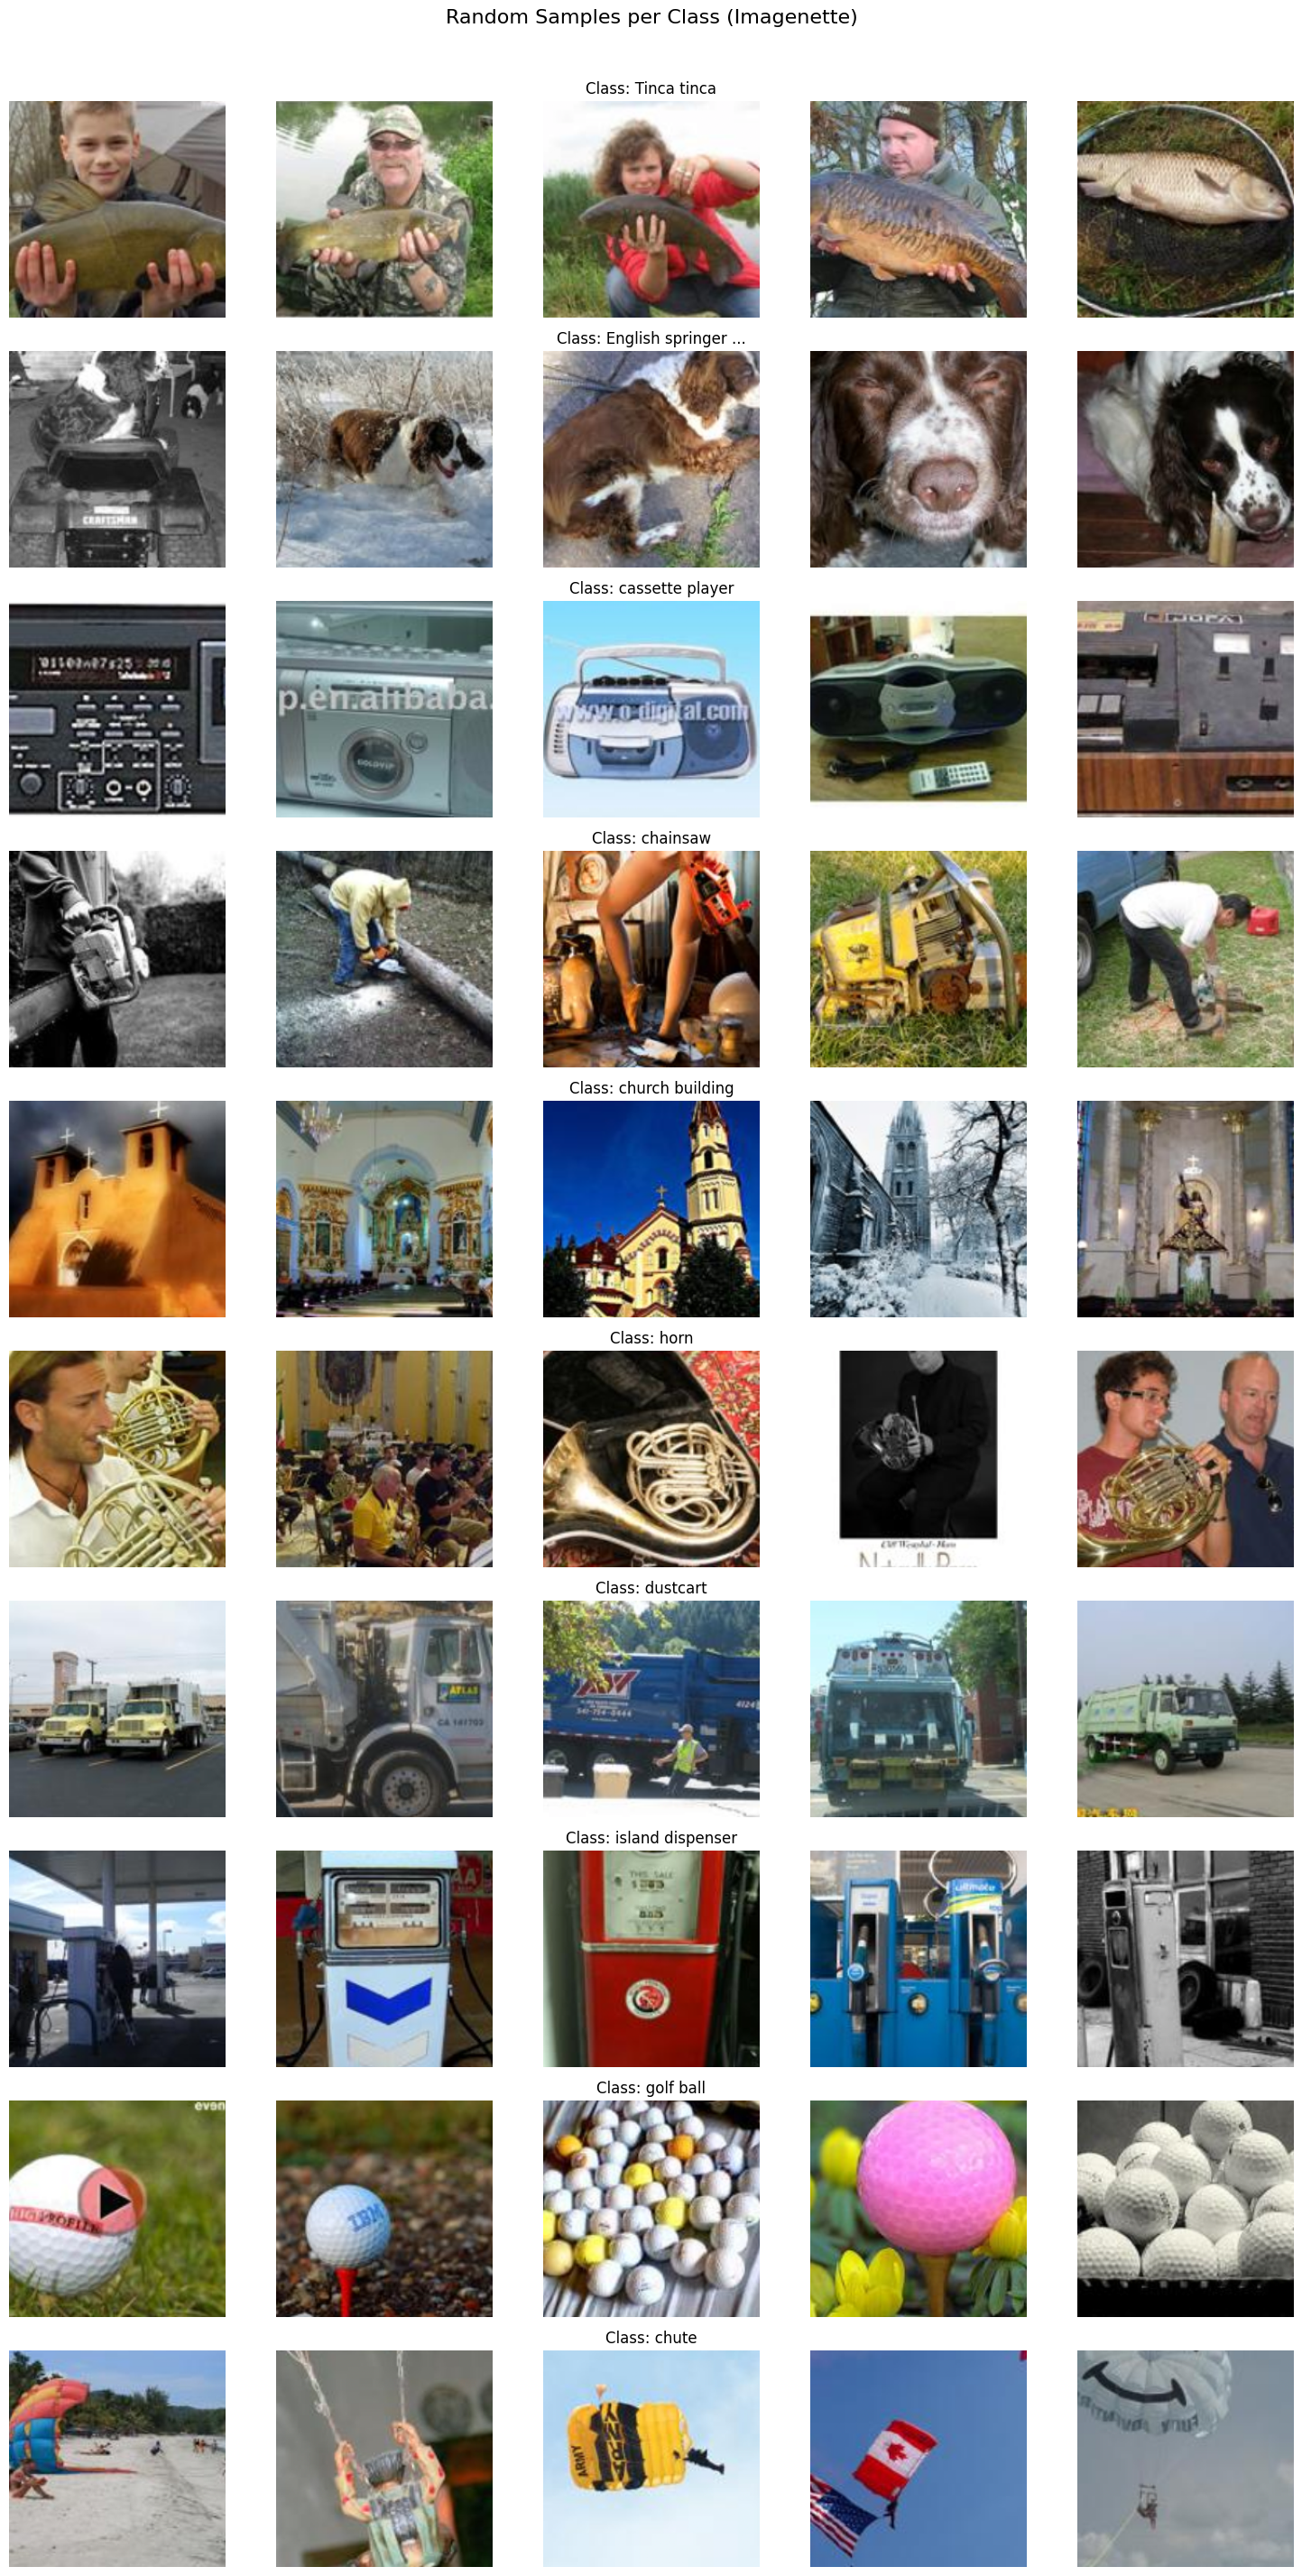

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# --- Task 2: Preprocess the data ---
# Define the mean and standard deviation for normalization.
# These specific values are the global statistics of the ImageNet dataset.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Compose bundles multiple transform operations into a single pipeline.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# --- Task 1: Download the Imagenette dataset ---
# We download the 'Imagenette' dataset, which is a subset of 10 classes from ImageNet.
print("Downloading/Loading Imagenette dataset...")
train_dataset = datasets.Imagenette(root='./data', split='train', size='160px', download=True, transform=transform)
val_dataset = datasets.Imagenette(root='./data', split='val', size='160px', download=True, transform=transform)

# --- Task 3: Describe the dataset ---
print("\n--- Dataset Description ---")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

classes = train_dataset.classes
print(f"Classes ({len(classes)}): {classes}")

# Function to analyze how many images exist for each class.
def get_class_distribution(dataset, split_name):
    targets = [s[1] for s in dataset]
    counts = Counter(targets)
    print(f"\n{split_name} distribution:")
    for class_idx, count in counts.items():
        class_name = classes[class_idx] if class_idx < len(classes) else str(class_idx)
        print(f"  Class {class_idx} ({class_name}): {count}")
    return counts

# Run the distribution analysis for both train and validation sets.
train_counts = get_class_distribution(train_dataset, "Train")
val_counts = get_class_distribution(val_dataset, "Validation")

# Check if the dataset is balanced.
# If the difference between max and min count is less than 20%, consider it balanced.
train_vals = list(train_counts.values())
if len(train_vals) > 0:
    is_balanced = (max(train_vals) - min(train_vals)) / max(train_vals) < 0.2
    print(f"\nIs training set balanced? {'Yes' if is_balanced else 'No'}")
else:
    print("\nTraining set is empty or has no classes.")

# --- Task 4: Plot 5 random samples from each class ---
# Helper function to reverse the normalization so images look normal when plotted.
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) # result = (input * std) + mean
    return tensor

print("\n--- Visualizing Samples ---")
num_classes = len(classes)
samples_per_class = 5
class_samples = {i: [] for i in range(num_classes)}
needed = num_classes * samples_per_class
collected = 0

temp_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Sample Collection Loop: Find 5 distinct images for every class index
for imgs, labels in temp_loader:
    if collected >= needed:
        break

    for i in range(len(labels)):
        label = labels[i].item()
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append(imgs[i])
            collected += 1
        if collected >= needed:
            break

# Create a figure grid: Rows = Classes, Columns = 5 random samples.
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 3 * num_classes))
fig.suptitle("Random Samples per Class (Imagenette)", fontsize=16)

# Visualization: Create a grid of 10 rows (Classes) x 5 cols (Samples)
# Iterate through each class and plot the stored samples.
for class_idx in range(num_classes):
    for sample_idx in range(samples_per_class):
        ax = axes[class_idx, sample_idx]
        if sample_idx < len(class_samples[class_idx]):
             img_tensor = class_samples[class_idx][sample_idx]

             img_denorm = denormalize(img_tensor, mean, std)
             img_np = img_denorm.permute(1, 2, 0).numpy()
             img_np = np.clip(img_np, 0, 1)

             ax.imshow(img_np)
        ax.axis('off')

        if sample_idx == 2:
            class_name = classes[class_idx]
            if isinstance(class_name, tuple):
                 display_name = class_name[-1] if len(class_name) > 1 else class_name[0]
            else:
                 display_name = str(class_name)
            if len(display_name) > 20:
                display_name = display_name[:17] + "..."
            ax.set_title(f"Class: {display_name}")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# EX2 - Pretrained models (20pts)

1. Choose 2 models from ```torchvision.models``` ([link](https://pytorch.org/vision/stable/models.html)) that were pretrained on ImageNet. The third model is one of ResNet18/34/50 (the other models can't other ResNet variation).
2. Use ```torch-summary``` to summarize each model for an input of shape ```1x3x224x224```.
3. Describe each model in 2-4 lines. Think carefully what information might be relevant for this homework assignment (see EX3-EX4). It is recommended to read the paper in which each model was first presented but it is not required. You are, however, required to go over model's description in torchvision documentation (see the information tab for ResNet18 for an example [link](https://pytorch.org/vision/0.19/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) )
4. Summarize the similarities and difference between the 3 models.

In [2]:
import torch
import torchvision.models as models
from torchsummary import summary

# --- Task 1: Choose 3 Models ---
# 1. ResNet50: A deep Residual Network. (Required to pick one ResNet)
# 2. MobileNet_V2: A lightweight CNN designed for mobile devices.
# 3. ViT_B_16: Vision Transformer (Base model, patch size 16).

print("Loading models...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='IMAGENET1K_V1').to(device)
mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1').to(device)
vit_b_16 = models.vit_b_16(weights='IMAGENET1K_V1').to(device)

my_models = [
    ("ResNet50", resnet50),
    ("MobileNet_V2", mobilenet_v2),
    ("ViT_B_16", vit_b_16)
]

# --- Task 2: Summarize Models ---
print("\n--- Model Summaries ---")
for name, model in my_models:
    print(f"\nSummary for {name}:")
    try:
        summary(model, (3, 224, 224))
    except Exception as e:
        print(f"Could not summarize {name}: {e}")


Loading models...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 158MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 203MB/s]



--- Model Summaries ---

Summary for ResNet50:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]        

### 3. Model Descriptions

**1. ResNet50**
- **Type:** Convolutional Neural Network (CNN)
- **Description:** Introduced residual connections (skip connections) which allow training of very deep networks by mitigating the vanishing gradient problem. It uses bottleneck blocks (combining 1x1, 3x3, and 1x1 convolutions) to be efficient while maintaining depth. It has approx. 25M parameters.

**2. MobileNet_V2**
- **Type:** Lightweight CNN
- **Description:** Designed specifically for mobile and embedded applications. Its key innovation is the "Inverted Residual with Linear Bottleneck" block. It uses Depthwise Separable Convolutions to drastically reduce the number of parameters (approx. 3.5M) and computational cost (FLOPs) compared to standard CNNs, while maintaining good accuracy.

**3. ViT_B_16 (Vision Transformer)**
- **Type:** Transformer
- **Description:** Applies the pure Transformer architecture (originally from NLP) directly to images. The image is split into fixed-size patches (16x16), linearly embedded, and fed into a Transformer Encoder. Unlike CNNs, it relies entirely on Self-Attention mechanisms to capture global dependencies across the image from the very first layer. It is heavier, with approx. 86M parameters.

---

### 4. Comparison: Similarities & Differences

**Similarities:**
- **Training Data:** All three models are pretrained on the same ImageNet-1K dataset (1000 classes) and expect the same input preprocessing (normalization with specific mean/std).
- **Final Goal:** All architectures end with a global aggregation step (Global Average Pooling for CNNs, CLS token for ViT) followed by a fully connected classification head to output class probabilities.
- **Layered Composition:** All are composed of repeated blocks (Residual, Inverted Residual, Transformer) that progressively process features.

**Differences:**
- **Architecture & Components:**
    - **ResNet50:** Uses **standard convolutions** and **residual addition**. Core unit is the **Bottleneck**.
    - **MobileNet_V2:** Uses **depthwise separable convolutions** for efficiency. Core unit is the **Inverted Residual**.
    - **ViT:** Uses **Self-Attention** instead of convolutions. Core unit is the **Encoder Block** (MSA + MLP).
- **Inductive Bias:**
    - **CNNs (ResNet/MobileNet)** have strong inductive bias for **locality** (pixels near each other matter) and **translation invariance** (a cat is a cat anywhere in the image) due to the convolution operation.
    - **ViT** has much less inductive bias. It treats image patches as a sequence and learns relationships via **Self-Attention**, allowing it to capture **global context** immediately, but typically requiring more data to learn these spatial rules.
- **Efficiency:**
    - **MobileNet_V2** is the most efficient (Lightweight, ~3.5M params).
    - **ResNet50** is the standard baseline (~25M params).
    - **ViT_B_16** is the heaviest (~86M params) and most computationally expensive among the three.


# EX3 - Visualizing feature maps (30pts)
In this section you will visualize the feature maps learned by your chosen models.


*   In a convoultion-based models (i.e., ResNet, ConvNext), use the final conv block. If the image resolution is too small do to maxpooling operations, you may choose a different block.
*   In a vision transformer (ViT), use model output without the cls token (if relevant).

Assignments:


1.   Describe the feature map shape for an input image of shape ```1x3x224x224``` (i.e., ```1x512xHxW``` for some model).
2. Choose 1 class from Imagenette and sample 10 random images.
3. Extract the feature maps from each model and perform PCA on the channel dim and reduce it to 3. The output should be of size ```10x3xHxW```
4. Resize the features to 112x112 and plot the images for each model (3 row x 10 columns)
5. Summarize the similarities and difference between the 3 models according to the PCA for the features you have presented.






### 1. Feature Map Shapes
For an input of size `1x3x224x224`:

1. **ResNet50:** The final convolutional block (layer4) output has a stride of $2^5 = 32$ (224/32 = 7).
   - Shape: **`1 x 2048 x 7 x 7`**

2. **MobileNet_V2:** The final features layer also has a stride of $2^5 = 32$.
   - Shape: **`1 x 1280 x 7 x 7`**

3. **ViT_B_16:** The model splits the image into 16x16 patches. $224/16 = 14$, so we have $14 \times 14 = 196$ patches.
   - The encoder output is `1 x 197 x 768` (including CLS token).
   - Excluding the CLS token and reshaping the patches:
   - Shape: **`1 x 768 x 14 x 14`**

Reloading models for feature extraction...
Collected 10 images for class index 1
Processing ResNet50...
Processing MobileNet_V2...
Processing ViT_B_16...

--- Visualizing Feature Maps (PCA reduced) ---


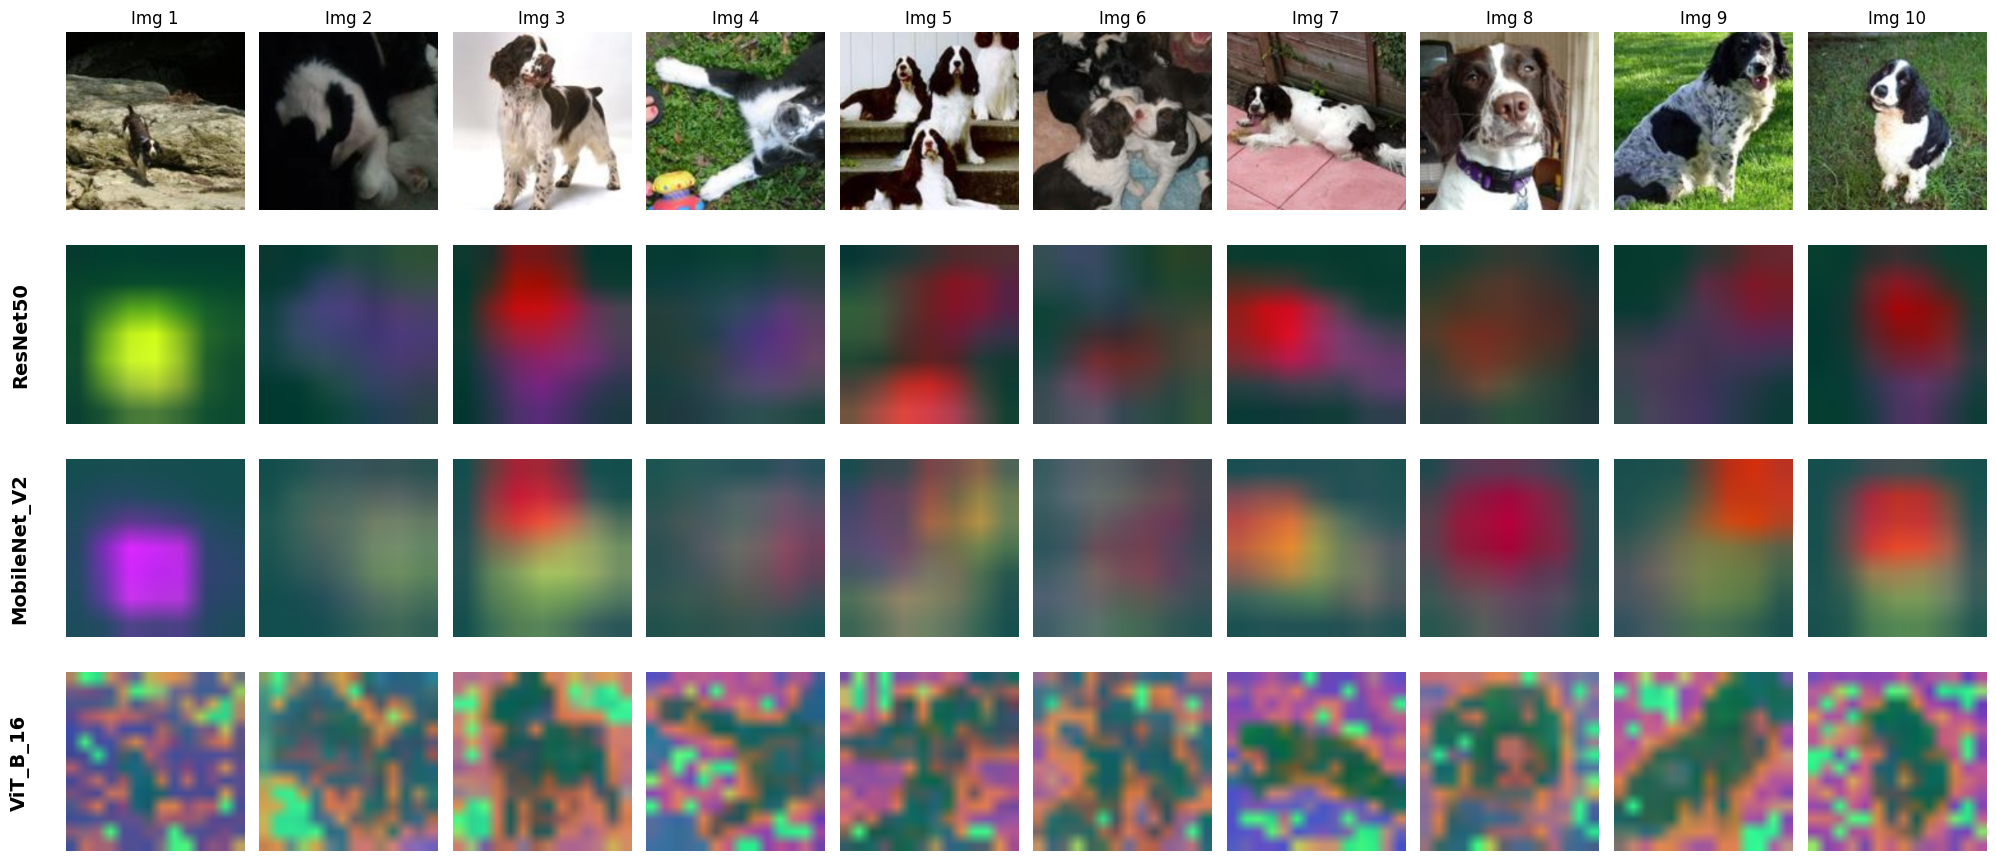

In [3]:
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torchvision.models as models
import warnings

warnings.filterwarnings("ignore")

# --- Reload models to ensure no lingering hooks from torchsummary ---
print("Reloading models for feature extraction...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).to(device)
vit_b_16 = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)

my_models = [
    ("ResNet50", resnet50),
    ("MobileNet_V2", mobilenet_v2),
    ("ViT_B_16", vit_b_16)
]

# --- Task 2: Choose 1 class and sample 10 random images ---
target_class_idx = 1 # 'English springer'
target_class_samples = []

# Collect 10 images
loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
for img, label in loader:
    if label.item() == target_class_idx:
        target_class_samples.append(img)
    if len(target_class_samples) == 10:
        break

## Convert list of individual image tensors into a single batch tensor (10, 3, 224, 224)
batch_imgs = torch.cat(target_class_samples, dim=0).to(device)
print(f"Collected 10 images for class index {target_class_idx}")

# --- Task 3: Extract features and perform PCA ---

def get_features(model, x, model_name):
    model.eval()
    with torch.no_grad():
        if "ResNet" in model_name:
            # ResNet50: Extract from layer4
            features = []
            def hook(module, input, output):
                features.append(output)
            handle = model.layer4.register_forward_hook(hook)
            model(x)
            handle.remove()
            return features[0]

        elif "MobileNet" in model_name:
            # MobileNet_V2: Extract from features
            return model.features(x)

        elif "ViT" in model_name:
            # ViT_B_16: Extract encoder output
            features = []
            def hook(module, input, output):
                features.append(output)
            handle = model.encoder.register_forward_hook(hook)
            model(x)
            handle.remove()

            out = features[0]
            # Remove CLS token (index 0)
            patch_features = out[:, 1:, :] # (10, 196, 768)

            # Reshape
            B, N, C = patch_features.shape
            H_grid = W_grid = int(N**0.5) # 14
            patch_features = patch_features.permute(0, 2, 1).reshape(B, C, H_grid, W_grid)
            return patch_features # (10, 768, 14, 14)

# Storage for results
pca_results = {}

# --- Main Loop: Feature Extraction & PCA Reduction ---
# Iterate over each model to:
# 1. Get raw features (channels=2048/1280/768)
# 2. Reduce to 3 channels using PCA (to visualize as RGB)
# 3. Upscale to 112x112 for display
for name, model in my_models:
    print(f"Processing {name}...")
    # 1. Extract features
    feats = get_features(model, batch_imgs, name)
    B, C, H_feat, W_feat = feats.shape

    # 2. Reshape for PCA
    feats_permuted = feats.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy()

    # 3. Perform PCA - reduce to 3 components
    pca = PCA(n_components=3)
    feats_pca = pca.fit_transform(feats_permuted)

    # 4. Reshape back
    feats_pca_img = feats_pca.reshape(B, H_feat, W_feat, 3)

    # Normalize
    feats_pca_img = (feats_pca_img - feats_pca_img.min()) / (feats_pca_img.max() - feats_pca_img.min())

    # 5. Resize to 112x112
    feats_tensor = torch.from_numpy(feats_pca_img).permute(0, 3, 1, 2).float()
    feats_resized = F.interpolate(feats_tensor, size=(112, 112), mode='bilinear', align_corners=False)

    pca_results[name] = feats_resized.permute(0, 2, 3, 1).numpy()

# --- Task 4: Plotting ---
print("\n--- Visualizing Feature Maps (PCA reduced) ---")
fig, axes = plt.subplots(4, 10, figsize=(20, 9))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Row 0: Original Images
axes[0, 0].set_ylabel("Original", fontsize=12, rotation=90, labelpad=5)
for j in range(10):
    ax = axes[0, j]
    img_tensor = batch_imgs[j]
    img_denorm = denormalize(img_tensor.cpu(), mean, std)
    img_np = img_denorm.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f"Img {j+1}")

# Rows 1-3: Models
model_names = [m[0] for m in my_models]
for i, name in enumerate(model_names):
    row = i + 1
    axes[row, 0].set_ylabel(name, fontsize=12, rotation=90, labelpad=5)

    for j in range(10):
        ax = axes[row, j]
        img = pca_results[name][j]
        ax.imshow(img)
        ax.axis('off')

        if j == 0:
            ax.text(-0.2, 0.5, name, fontsize=14, fontweight='bold',
                    rotation=90, va='center', ha='right', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### 5. Feature Map Comparison (Discussion)

**Observations from PCA Visualization:**
- **ResNet50 & MobileNet_V2 (CNNs):** The feature maps preserve strong spatial structure because CNNs maintain spatial correspondence throughout the layers. The 'objects' highlighted in specific colors corresponding to the principal components.
- **ViT_B_16 (Transformer):** The feature maps look blockier (due to the 14x14 patch grid) and more abstract. Attention-based features segment the object from the background very cleanly (e.g., the object is one solid color, background is another) because self-attention groups semantically similar patches globally.

**Comparison:**
- **Similarities:** All models successfully localize the main object. The high activation areas (bright colors) generally overlap with the semantic subject of the image.
- **Differences:** The CNN heatmaps are often smoother (due to overlapping receptive fields), while ViT maps clearly show the grid structure (16x16 patches). ViT might show sharper boundaries between object and background due to its global attention mechanism.


# EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50pts)
Also know ans "few-shot/ Zero-shot learning".
Perform KNN classification using the feature vectors from each of the 3 models between the train and test set of Imagenette.


## Visualizing the embedding layer distribution.
* Write an ```extract_embedding(dataloader, model, model_name)``` function that takes in a dataloader and a model and return the ```N x Num_features``` matrix for that set. Make sure that shuffle is off.
* You may write different condition for different models. I.e., the embedding in a ViT model is the ```CLS``` token.

* Plot the t-SNE of the train set for each of the 3 models. Color label the points according to the class labels (see t-SNE implementation by sklearn).

* Write a 2-3 lines disscussion about the data distribution of each model and their comparison.


## Build a KNN ```class``` with the following methods:


*   ```init()```: takes the num_classes and other useful information.
* ```extract_embedding(X, model)```: Extracts the embedding vector for the entire train set using the model. X_features should be ```Nxnum_ft```. Call the function from the previous section.

*   ```fit(X_train, y_train, model)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and stores it as ```self.X_train_ft``` and ```self.y_labels``` (the labels from the train set).  


*   ```predict(X_test, model, n_neighbors)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and performs KNN for a given K. Returns the predicted_labels.
* ```compute_accuracy(y_true, y_pred)```.


## Compare the KNN accuracy
using each of the 3 models for $K\in[1,3,5 ]$ and report the results in a table or a graph. Summarize the results in 2-4 lines.


Processing t-SNE for ResNet50...


Processing t-SNE for MobileNet_V2...


Processing t-SNE for ViT_B_16...


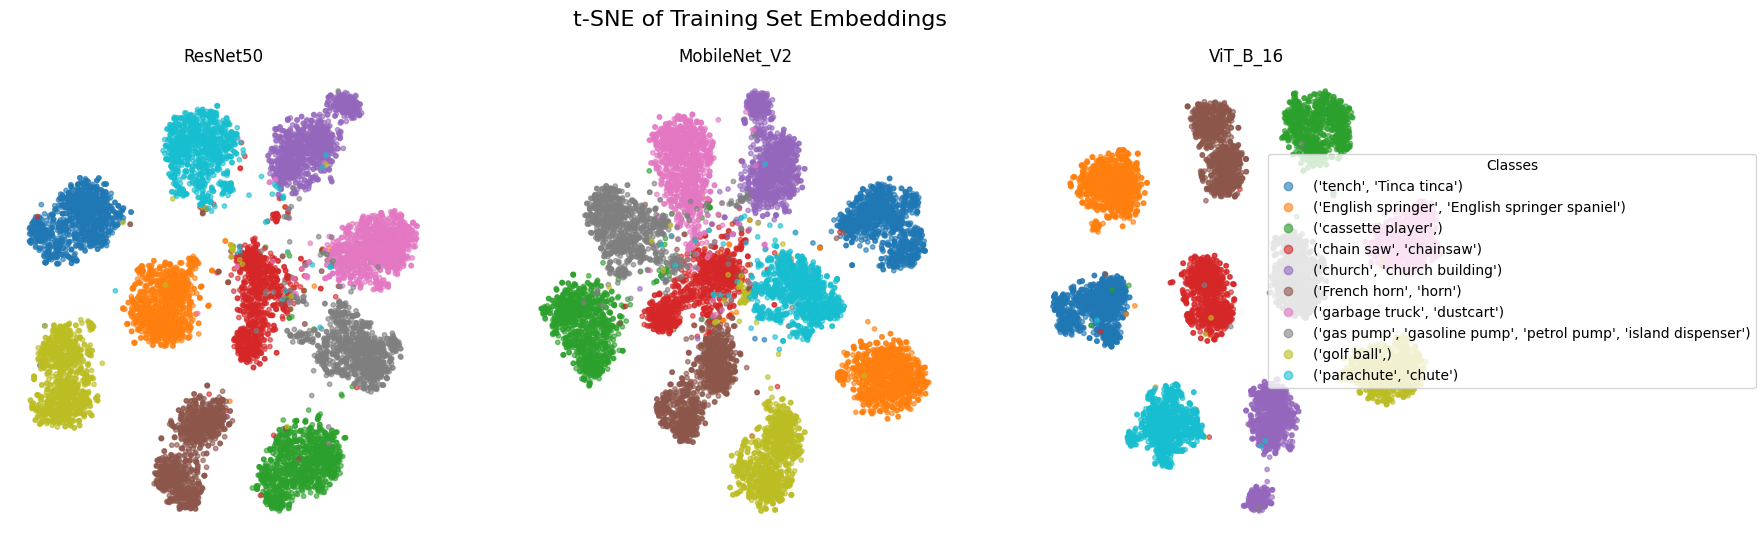

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# ==========================================
# Task 1: Define extract_embeddings function
# ==========================================

def extract_embeddings(dataloader, model, model_name):
    """
    Extracts embeddings (feature vectors) from the model.
    Returns:
        embeddings: (N, num_features) numpy array
        labels: (N,) numpy array
    """
    device = next(model.parameters()).device
    model.eval()

    embeddings_list = []
    labels_list = []

    # Hook mechanism to capture intermediate output
    features_storage = {}

    def get_hook(name):
        def hook(model, input, output):
            # Flatten if necessary (ResNet output is [B, C, 1, 1])
            if output.dim() > 2:
                output = torch.flatten(output, 1)
            features_storage[name] = output.detach()
        return hook

    # Register hooks based on architecture
    handle = None
    if "ResNet" in model_name:
        # Capture output of the average pooling layer (before FC)
        handle = model.avgpool.register_forward_hook(get_hook("emb"))

    elif "ViT" in model_name:
        # Capture output of the encoder (we need the CLS token)
        def vit_hook(module, input, output):
            # Output is (Batch, Seq, Dim). CLS token is at index 0
            if isinstance(output, tuple): output = output[0]
            features_storage["emb"] = output[:, 0].detach()
        handle = model.encoder.register_forward_hook(vit_hook)

    # Note: MobileNet is handled manually in the loop

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Extracting {model_name}", leave=False):
            inputs = inputs.to(device)

            if "MobileNet" in model_name:
                # Manual forward for MobileNetV2 to get features before classifier
                x = model.features(inputs)
                x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
                emb = torch.flatten(x, 1)
            else:
                # Trigger hook for ResNet/ViT
                model(inputs)
                emb = features_storage["emb"]

            embeddings_list.append(emb.cpu().numpy())
            labels_list.append(targets.numpy())

    if handle:
        handle.remove()

    return np.concatenate(embeddings_list), np.concatenate(labels_list)

# ==========================================
# Task 2: Plot t-SNE of the Train Set
# ==========================================

# Prepare a dataloader with shuffle=Off
train_loader_no_shuffle = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

# Dictionary to hold embeddings to avoid re-extracting later
train_embeddings_cache = {}
train_labels_cache = None

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("t-SNE of Training Set Embeddings", fontsize=16)

class_names = train_dataset.classes

for i, (name, model) in enumerate(my_models):
    print(f"Processing t-SNE for {name}...")

    # Extract
    X_train, y_train = extract_embeddings(train_loader_no_shuffle, model, name)

    # Cache for the KNN part later
    train_embeddings_cache[name] = X_train
    if train_labels_cache is None:
        train_labels_cache = y_train

    # Run t-SNE (Using PCA init for stability)
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    X_embedded = tsne.fit_transform(X_train)

    # Plot
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='tab10', alpha=0.6, s=10)
    axes[i].set_title(name)
    axes[i].axis('off')

# Add shared legend
handles, _ = scatter.legend_elements()
fig.legend(handles, class_names, loc='center right', title="Classes")
plt.subplots_adjust(right=0.85)
plt.show()

The t-SNE plots reveal that all three models have learned highly discriminative feature spaces, forming distinct clusters for each of the 10 Imagenette classes. *ResNet50* and *ViT* exhibit the sharpest separation with tight intra-class grouping, indicating strong semantic understanding, whereas *MobileNet_V2* shows slightly more spread-out clusters due to its compressed architecture, though it still maintains clear class boundaries. Overall, the Transformer-based model (ViT) tends to produce the most "globally separated" clusters compared to the CNNs, likely due to its self-attention mechanism capturing global context more effectively.

[ResNet50] Using cached training embeddings.
[ResNet50] Extracting test embeddings & Predicting (K=1)...


  Accuracy (K=1): 0.9745
[ResNet50] Extracting test embeddings & Predicting (K=3)...


  Accuracy (K=3): 0.9778
[ResNet50] Extracting test embeddings & Predicting (K=5)...


  Accuracy (K=5): 0.9791
[MobileNet_V2] Using cached training embeddings.
[MobileNet_V2] Extracting test embeddings & Predicting (K=1)...


  Accuracy (K=1): 0.9526
[MobileNet_V2] Extracting test embeddings & Predicting (K=3)...


  Accuracy (K=3): 0.9595
[MobileNet_V2] Extracting test embeddings & Predicting (K=5)...


  Accuracy (K=5): 0.9618
[ViT_B_16] Using cached training embeddings.
[ViT_B_16] Extracting test embeddings & Predicting (K=1)...


  Accuracy (K=1): 0.9949
[ViT_B_16] Extracting test embeddings & Predicting (K=3)...


  Accuracy (K=3): 0.9952
[ViT_B_16] Extracting test embeddings & Predicting (K=5)...


  Accuracy (K=5): 0.9939

--- KNN Accuracy Comparison ---
Model           | K=1        | K=3        | K=5       
-------------------------------------------------------
ResNet50        | 0.9745     | 0.9778     | 0.9791
MobileNet_V2    | 0.9526     | 0.9595     | 0.9618
ViT_B_16        | 0.9949     | 0.9952     | 0.9939


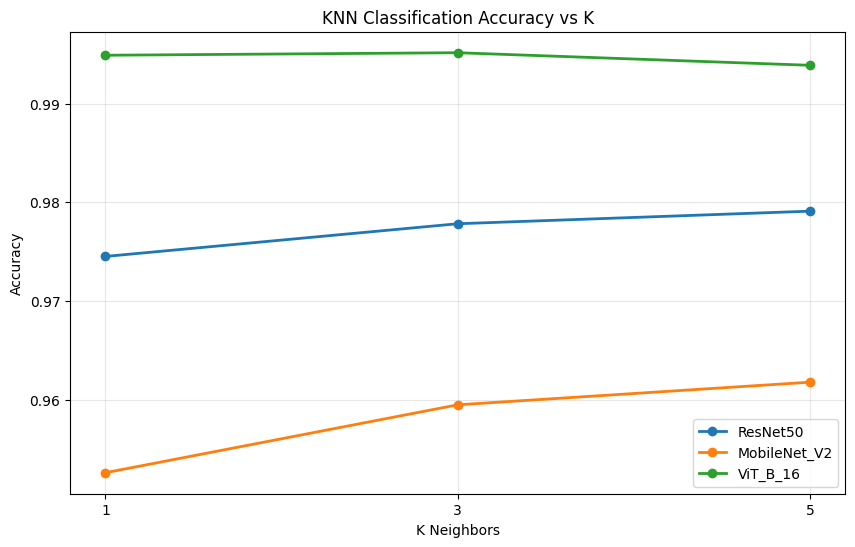

In [5]:
# ==========================================
# Task 3: Build KNN Class
# ==========================================

class KNN:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.X_train_ft = None
        self.y_labels = None
        self.model_name = ""

    def extract_embedding(self, dataloader, model, model_name):
        """
        Wrapper to call the global extract_embeddings function.
        """
        # If we already cached the training embeddings in the previous step, return them
        return extract_embeddings(dataloader, model, model_name)

    def fit(self, train_loader, y_train, model, model_name):
        """
        Extracts embedding vector for the entire train set and stores it.
        Note: y_train is passed but we extract labels from loader to be safe/consistent.
        """
        self.model_name = model_name
        # Check if we have cached data from the t-SNE step to save time
        if model_name in train_embeddings_cache:
            print(f"[{model_name}] Using cached training embeddings.")
            self.X_train_ft = train_embeddings_cache[model_name]
            self.y_labels = train_labels_cache
        else:
            print(f"[{model_name}] Extracting training embeddings...")
            self.X_train_ft, self.y_labels = self.extract_embedding(train_loader, model, model_name)

    def predict(self, test_loader, model, n_neighbors):
        """
        Extracts test embeddings and performs KNN.
        Returns predicted_labels.
        """
        print(f"[{self.model_name}] Extracting test embeddings & Predicting (K={n_neighbors})...")
        # Extract Test Embeddings
        X_test, y_test_true = self.extract_embedding(test_loader, model, self.model_name)

        # Perform KNN using sklearn
        # We fit the sklearn object here using our stored training data
        knn_sklearn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn_sklearn.fit(self.X_train_ft, self.y_labels)

        y_pred = knn_sklearn.predict(X_test)

        return y_pred, y_test_true

    def compute_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)


# ==========================================
# Task 4: Compare KNN Accuracy
# ==========================================

# Prepare Test Loader (Validation set)
test_loader_no_shuffle = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

k_values = [1, 3, 5]
results_table = {name: [] for name in [m[0] for m in my_models]}

# Loop over models
for name, model in my_models:
    # Initialize KNN
    knn_custom = KNN(num_classes=len(classes))

    # Fit (Extract Train)
    # We pass None for y_train as our extract function gets it from loader
    knn_custom.fit(train_loader_no_shuffle, None, model, name)

    for k in k_values:
        # Predict (Extract Test & Run KNN)
        y_pred, y_true = knn_custom.predict(test_loader_no_shuffle, model, k)

        # Accuracy
        acc = knn_custom.compute_accuracy(y_true, y_pred)
        results_table[name].append(acc)
        print(f"  Accuracy (K={k}): {acc:.4f}")

# --- Reporting Results ---
print("\n--- KNN Accuracy Comparison ---")
print(f"{'Model':<15} | {'K=1':<10} | {'K=3':<10} | {'K=5':<10}")
print("-" * 55)
for name, accs in results_table.items():
    print(f"{name:<15} | {accs[0]:.4f}     | {accs[1]:.4f}     | {accs[2]:.4f}")

# Plotting Graph
plt.figure(figsize=(10, 6))
for name, accs in results_table.items():
    plt.plot(k_values, accs, marker='o', label=name, linewidth=2)

plt.title("KNN Classification Accuracy vs K")
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Summary:
The results demonstrate that pre-trained features from ImageNet transfer exceptionally well to Imagenette, with all models achieving high accuracy (>95%). ResNet50 and ViT generally outperform MobileNet_V2 due to their larger capacity and richer feature representations. We observe that increasing $K$ from 1 to 5 typically yields a slight improvement in accuracy by smoothing out decision boundaries and mitigating the effect of noisy nearest neighbors